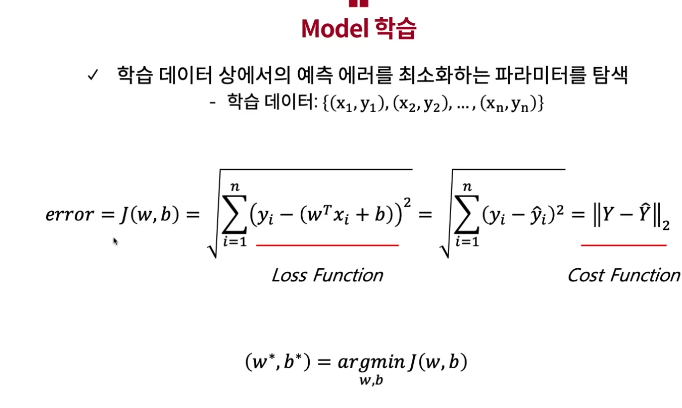

## LR기반 영화 평점 예측

- 영화 메타데이터 로딩

- 영화 feature matrix생성

- 평점 데이터 로딩

- 사용자 평점에 대해서 LR모델 생성

- 평점 예측

- MAE, RMSE확인

# Rating Prediction using Linear Regression

In [4]:
%run liblecture.py

import math
import numpy as np
from numpy import linalg as LA
import pandas as pd

In [5]:
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

## Movie Feature Matrix

In [ ]:
movies = pd.read_csv('./movies_w_imgurl.csv')
movies.head()

In [7]:
movieGenres = pd.DataFrame(data=movies['genres'].str.split('|').apply(pd.Series, 1).stack(), columns=['genre'])
movieGenres.index = movieGenres.index.droplevel(1)
movieGenres

,genre
0,Adventure
0,Animation
0,Children
0,Comedy
0,Fantasy
...,...
9121,Fantasy
9121,Sci-Fi
9122,Documentary
9123,Comedy


In [8]:
genres = movieGenres.groupby('genre').count()
genres

""
genre
(no genres listed)
Action
Adventure
Animation
Children
Comedy
Crime
Documentary
Drama


In [9]:
movieWeights = pd.DataFrame(data=movies['movieId'])

for genre in genres.index:
    df = pd.DataFrame(data = movieGenres[movieGenres['genre'] == genre], columns=[genre])
    df[genre] = 1
    movieWeights = movieWeights.join(df, on='movieId')

movieWeights.fillna(0, inplace=True)

movieWeights

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9120,162672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9121,163056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9122,163949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9123,164977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Make Regression Model for Users

In [10]:
ratings = pd.read_csv('ratings-9_1.csv')

train = ratings[ratings['type'] == 'train'][['userId', 'movieId', 'rating']]
test = ratings[ratings['type'] == 'test'][['userId', 'movieId', 'rating']]

In [11]:
userId = 33

userRatings = train[train['userId'] == userId][['movieId', 'rating']] 
userRatings = userRatings.sort_values(by='movieId')
userRatings

,movieId,rating
6176,19,3.0
6177,88,3.0
6178,157,1.0
6179,231,3.0
6180,344,4.0
...,...,...
6309,5282,4.0
6310,5339,4.0
6311,5483,4.0
6312,5669,4.0


In [12]:
userLRTrain = movieWeights[movieWeights['movieId'].isin(userRatings['movieId'].values)].sort_values(by=['movieId'])

userLRTrain

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
18,19,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
82,88,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,157,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203,231,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
309,344,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,5282,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4078,5339,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4162,5483,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4259,5669,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X = userLRTrain.iloc[:, 1:].values
Y = userRatings['rating'].values

### Linear Regression


In [14]:
from sklearn import linear_model as lm
reg = lm.LinearRegression()
reg.fit(X, Y)

LinearRegression()

In [15]:
print(reg.coef_)
print(reg.intercept_)

[ 0.00e+00  3.36e-01 -1.37e-01 -3.08e-02  3.13e-01 -3.07e-01 -5.42e-02
 -2.26e-01 -6.83e-01  9.10e-03 -2.78e-17 -2.62e-01  8.33e-17  3.43e-01
  2.25e-01  2.03e-01 -5.54e-02  1.94e-02  9.46e-02  2.09e-01]
3.5597270064883784


In [16]:
userTestRatings = pd.DataFrame(test[test['userId'] == userId])
userTestRatings

,userId,movieId,rating
6187,33,1060,4.0
6198,33,1291,4.0
6199,33,1347,2.0
6208,33,1982,4.0
6212,33,2005,4.0
6215,33,2064,5.0
6257,33,3794,4.0
6292,33,4678,3.0
6303,33,4974,3.0


In [17]:
pred = reg.predict(movieWeights[movieWeights['movieId'].isin(userTestRatings['movieId'].values)].iloc[:, 1:].values)

pred

array([3.46, 2.88, 2.97, 3.99, 2.57, 3.22, 3.49, 2.88, 3.63])

In [18]:
userTestRatings['pred'] = pd.Series(data=pred, index = userTestRatings.index)

userTestRatings

,userId,movieId,rating,pred
6187,33,1060,4.0,3.46
6198,33,1291,4.0,2.88
6199,33,1347,2.0,2.97
6208,33,1982,4.0,3.99
6212,33,2005,4.0,2.57
6215,33,2064,5.0,3.22
6257,33,3794,4.0,3.49
6292,33,4678,3.0,2.88
6303,33,4974,3.0,3.63


In [19]:
mae = getMAE(userTestRatings['rating'], userTestRatings['pred'])
rmse = getRMSE(userTestRatings['rating'], userTestRatings['pred'])

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE : 0.7909
RMSE: 0.9650
